# Hackathon Autonomous Machines

### Imports

In [1]:
"""
@author: amirjaved
"""

import pandas as pd # data analysis toolkit - create, read, update, delete datasets
import numpy as np #matrix math
from sklearn.model_selection import train_test_split #to split out training and testing data
#keras is a high level wrapper on top of tensorflow (machine learning library)
#The Sequential container is a linear stack of layers

import tensorflow as tf
from tensorflow.keras.models import Sequential
#popular optimization strategy that uses gradient descent 
from tensorflow.keras.optimizers import Adam
#to save our model periodically as checkpoints for loading later
from tensorflow.keras.callbacks import ModelCheckpoint
#what types of layers do we want our model to have?
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
#helper class to define input shape and generate training images given image paths & steering angles
from utils import INPUT_SHAPE, batch_generator
#for reading files
import os

#for debugging, allows for reproducible (deterministic) results 
np.random.seed(0)

RAW_DATA_DIR = 'data/'
#PROCESSED_DATA_DIR = 'data_processed/'
# The size of the figures in this notebook
FIGURE_SIZE = (10,10)


#### configuring the gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


### Data Loader Function

In [2]:
def load_data(params):
    """
    Load training data and split it into training and validation set
    """
    #reads CSV file into a single dataframe variable

    #read log data file and renaming columns
    data_df = pd.read_csv(os.path.join(params['data_dir'], 'data.csv'), sep=',')
    data_df = data_df.rename(columns=({'Unnamed: 0':'image_path','dist_0':'distance','ABS_RX':'steering_angle','ABS_Y':'speed'}))

    #we'll store the camera images as our input data
    X = data_df[['image_path']].values
    #and our steering commands as our output data
    y = data_df['steering_angle'].values

    #now we can split the data into a training (80), testing(20), and validation set
    #thanks scikit learn
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=params['test_size'], random_state=0)

    return X_train, X_valid, y_train, y_valid

### Build Model Function

In [3]:
def build_model(params):
    """
    ###NVIDIA model used
    Image normalization to avoid saturation and make gradients work better.
    Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
    Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
    Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
    Drop out (0.5)
    Fully connected: neurons: 100, activation: ELU
    Fully connected: neurons: 50, activation: ELU
    Fully connected: neurons: 10, activation: ELU
    Fully connected: neurons: 1 (output)

    # the convolution layers are meant to handle feature engineering
    the fully connected layer for predicting the steering angle.
    dropout avoids overfitting
    ELU(Exponential linear unit) function takes care of the Vanishing gradient problem. 
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='elu',  input_shape=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', input_shape=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', input_shape=(2, 2)))
    model.add(Dropout(params['keep_prob']))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()

    return model

### Training 

In [4]:
def train_model(model, params, X_train, X_valid, y_train, y_valid):
    """
    Train the model
    """
    #Saves the model after every epoch.
    #quantity to monitor, verbosity i.e logging mode (0 or 1), 
    #if save_best_only is true the latest best model according to the quantity monitored will not be overwritten.
    #mode: one of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save file is
    # made based on either the maximization or the minimization of the monitored quantity. For val_acc, 
    #this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically
    # inferred from the name of the monitored quantity.
    checkpoint = ModelCheckpoint('trained_model_weights/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=params['save_best_only'],
                                 mode='auto')

    #calculate the difference between expected steering angle and actual steering angle
    #square the difference
    #add up all those differences for as many data points as we have
    #divide by the number of them
    #that value is our mean squared error! this is what we want to minimize via
    #gradient descent
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=params['learning_rate']))

    #Fits the model on data generated batch-by-batch by a Python generator.

    #The generator is run in parallel to the model, for efficiency. 
    #For instance, this allows you to do real-time data augmentation on images on CPU in 
    #parallel to training your model on GPU.
    #so we reshape our data into their appropriate batches and train our model simulatenously
    loss = model.fit_generator(batch_generator(params['data_dir'], X_train, y_train, params['batch_size'], True),
                        params['samples_per_epoch'],
                        params['nb_epoch'],
                        validation_data=batch_generator(params['data_dir'], X_valid, y_valid, params['batch_size'], False),
                        validation_steps=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)
    return loss

### Main Entry Point

In [5]:
#### main starting point
"""
Load train/validation data set and train the model
"""
params = {
    'data_dir': 'data/',
    'test_size': 0.2,
    'keep_prob': 0.5,
    'nb_epoch':200,
    'samples_per_epoch':100,
    'batch_size': 25,
    'save_best_only':'true',
    'learning_rate': 1.0e-4
}

#print parameters
print('-' * 30)
print('Parameters')
print('-' * 30)
for key, value in params.items():
    print('{:<20} := {}'.format(key, value))
print('-' * 30)

#load data
data = load_data(params)
#build model
model = build_model(params)
#train model on data, it saves as model.h5 
loss = train_model(model, params, *data)

------------------------------
Parameters
------------------------------
data_dir             := data/
test_size            := 0.2
keep_prob            := 0.5
nb_epoch             := 200
samples_per_epoch    := 100
batch_size           := 25
save_best_only       := true
learning_rate        := 0.0001
------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 480, 640, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 128, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 25, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 5, 48)          43248     
_____________________________________________________

100/100 [==============================] - 129s 1s/step - loss: 0.0983 - val_loss: 0.1855
Epoch 59/200
100/100 [==============================] - 131s 1s/step - loss: 0.1005 - val_loss: 0.1870
Epoch 60/200
100/100 [==============================] - 130s 1s/step - loss: 0.0969 - val_loss: 0.1797
Epoch 61/200
100/100 [==============================] - 130s 1s/step - loss: 0.0963 - val_loss: 0.1820
Epoch 62/200
100/100 [==============================] - 129s 1s/step - loss: 0.0933 - val_loss: 0.1751
Epoch 63/200
100/100 [==============================] - 131s 1s/step - loss: 0.0981 - val_loss: 0.1768
Epoch 64/200
100/100 [==============================] - 131s 1s/step - loss: 0.0924 - val_loss: 0.1741
Epoch 65/200
100/100 [==============================] - 131s 1s/step - loss: 0.0893 - val_loss: 0.1793
Epoch 66/200
100/100 [==============================] - 129s 1s/step - loss: 0.0887 - val_loss: 0.1759
Epoch 67/200
100/100 [==============================] - 130s 1s/step - loss: 0.0921 - 

100/100 [==============================] - 132s 1s/step - loss: 0.0491 - val_loss: 0.1788
Epoch 138/200
100/100 [==============================] - 131s 1s/step - loss: 0.0535 - val_loss: 0.1886
Epoch 139/200
100/100 [==============================] - 132s 1s/step - loss: 0.0499 - val_loss: 0.1743
Epoch 140/200
100/100 [==============================] - 131s 1s/step - loss: 0.0508 - val_loss: 0.1823
Epoch 141/200
100/100 [==============================] - 131s 1s/step - loss: 0.0487 - val_loss: 0.1754
Epoch 142/200
100/100 [==============================] - 130s 1s/step - loss: 0.0506 - val_loss: 0.1738
Epoch 143/200
100/100 [==============================] - 132s 1s/step - loss: 0.0489 - val_loss: 0.1808
Epoch 144/200
100/100 [==============================] - 131s 1s/step - loss: 0.0470 - val_loss: 0.1768
Epoch 145/200
100/100 [==============================] - 132s 1s/step - loss: 0.0533 - val_loss: 0.1723
Epoch 146/200
100/100 [==============================] - 132s 1s/step - loss: 

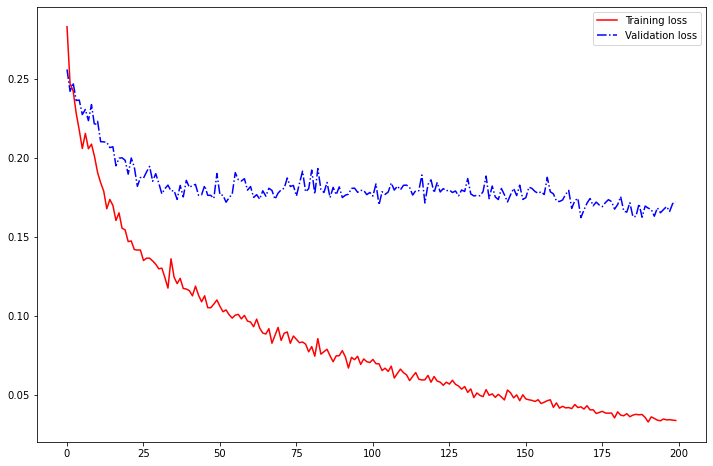

In [7]:
import matplotlib.pyplot as plt
loss_arr = loss.history['loss']
val_loss_arr = loss.history['val_loss']

epochs = range(len(loss_arr))
plt.figure(figsize=(12,8))

plt.plot(epochs, loss_arr, 'r', label='Training loss')
plt.plot(epochs, val_loss_arr, 'b-.', label='Validation loss')
plt.legend()

plt.show()